## Analyze CSV file

In [1]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages "
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.6,"
    "org.apache.spark:spark-streaming-kafka-0-10_2.12:3.5.6 "
    "pyspark-shell"
)

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("read_test_straeam") \
        .getOrCreate()

final_df = spark.read.csv("/home/guest/notebooks/data/output/date=*/hour=*", header=True, inferSchema=True)
final_df.take(5)

from pyspark.sql.functions import col

final_df.orderBy(col("window_start").asc()).coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("/home/guest/notebooks/final_output/")

:: loading settings :: url = jar:file:/home/guest/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/guest/.ivy2/cache
The jars for the packages stored in: /home/guest/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ac8a33ad-e424-4ef9-8838-5651bd2667fb;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.6 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.6 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in c

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
# Using '*' pattern 
print('\nFile name:\n')
for name in glob.glob('/home/guest/notebooks/final_output/*.csv'):
    print(name)


File name:

/home/guest/notebooks/final_output/part-00000-8848a87a-0a1e-440c-98a0-471457acebfb-c000.csv


In [4]:
pandas_df = pd.read_csv(f"{name}")
pandas_df.tail()

,sensor,count_obs,avg_obs,+/-std_obs,max_obs,min_obs,sum_miss_obs,max_time_delay,window_start,window_end
63,sensor-2,36,3.491,3.148,9.633,-0.251,0,95.0,2025-06-27T11:21:00.000Z,2025-06-27T11:22:00.000Z
64,sensor-1,23,1.704,3.290,5.428,-0.034,0,107.0,2025-06-27T11:21:00.000Z,2025-06-27T11:22:00.000Z
65,sensor-1,25,2.031,2.903,7.428,-0.208,0,105.0,2025-06-27T11:22:00.000Z,2025-06-27T11:23:00.000Z
66,sensor-2,20,2.033,3.252,9.031,-0.045,1,95.0,2025-06-27T11:22:00.000Z,2025-06-27T11:23:00.000Z
67,sensor-3,29,0.122,2.819,4.832,-0.350,0,9.0,2025-06-27T11:22:00.000Z,2025-06-27T11:23:00.000Z


In [5]:
pandas_df["datetime"] = pd.to_datetime(pandas_df["window_end"])

In [6]:
sorted_df = pandas_df.sort_values(by='datetime').set_index("datetime")

In [7]:
sorted_df.groupby("sensor").avg_obs.sum()

sensor
sensor-1    188.251
sensor-2     81.639
sensor-3    106.947
Name: avg_obs, dtype: float64

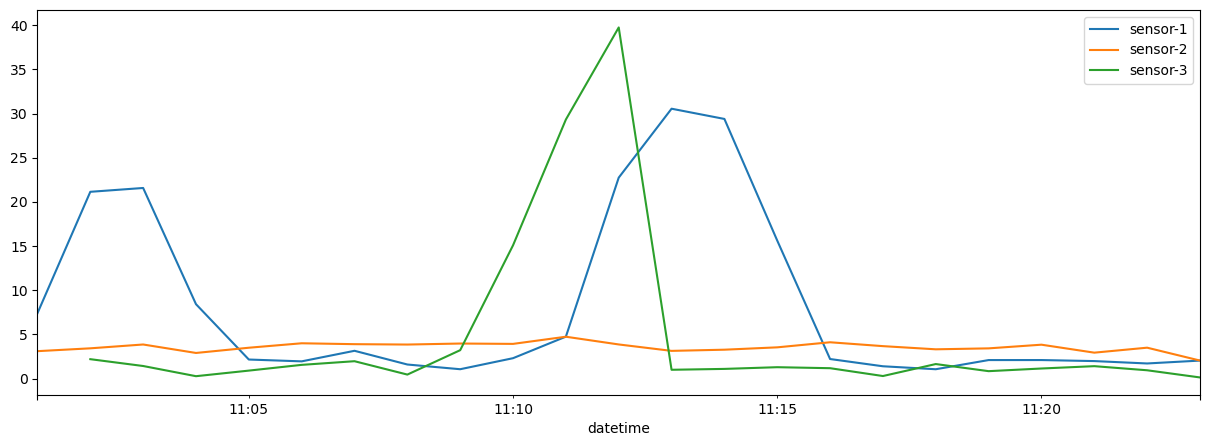

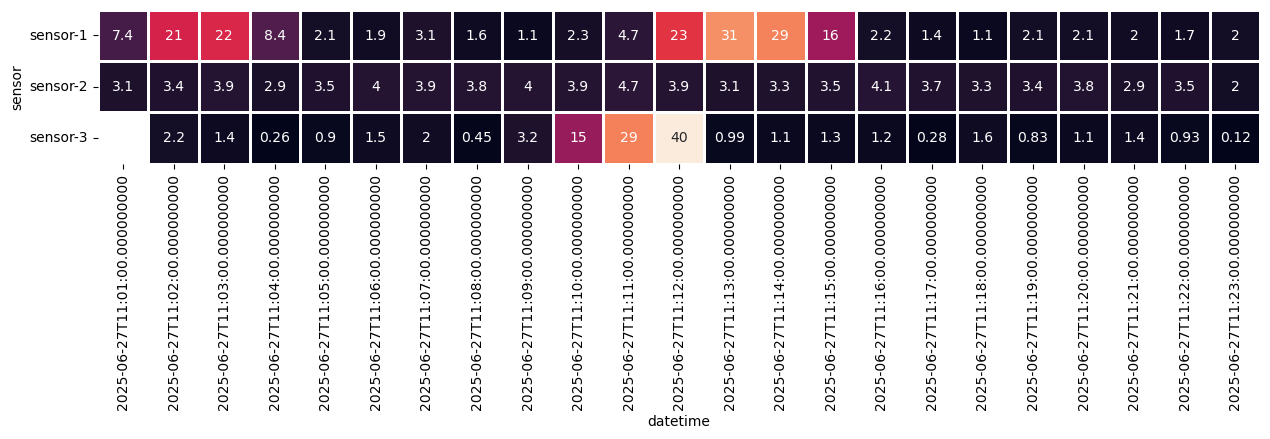

In [8]:
df_avg = sorted_df[["sensor", "avg_obs"]].pivot(columns='sensor', values='avg_obs')

sorted_df.groupby("sensor").avg_obs.plot(figsize=(15,5))
plt.legend()
plt.plot()

plt.figure(figsize=(15, 2))
sns.heatmap(df_avg.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()

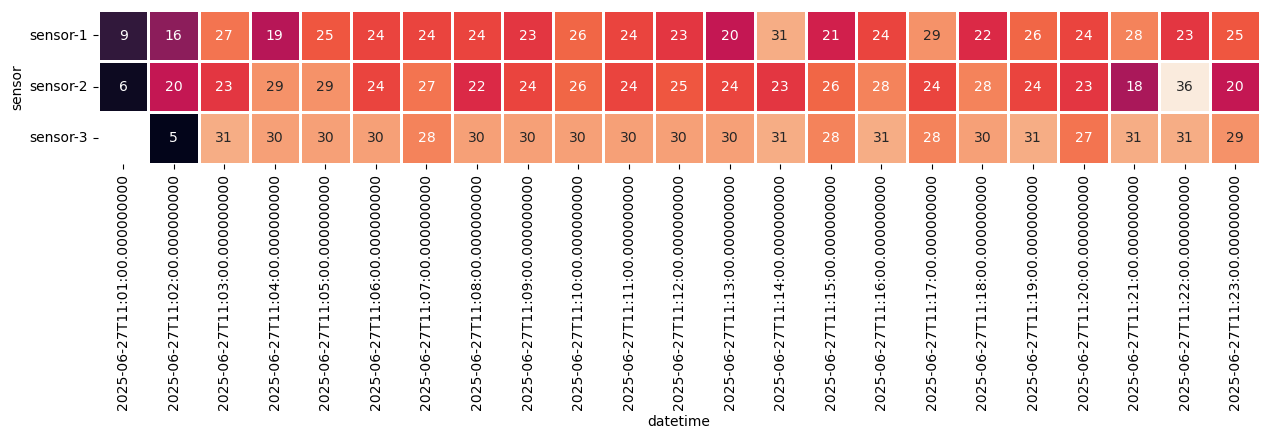

In [9]:
df_counts = sorted_df[["sensor", "count_obs"]].pivot(columns='sensor', values='count_obs')

plt.figure(figsize=(15, 2))
sns.heatmap(df_counts.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()

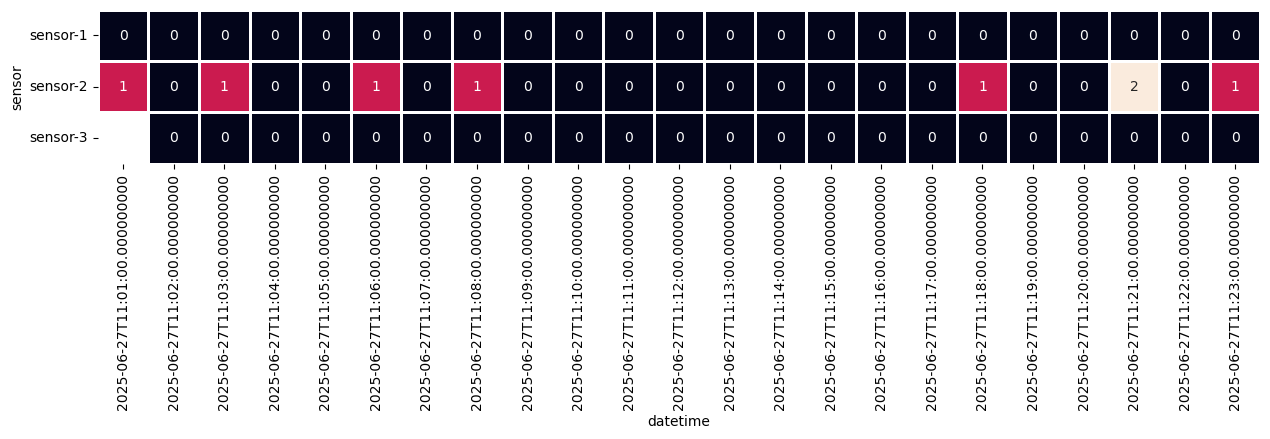

In [10]:
df_misses = sorted_df[["sensor", "sum_miss_obs"]].pivot(columns='sensor', values='sum_miss_obs')

plt.figure(figsize=(15, 2))
sns.heatmap(df_misses.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()


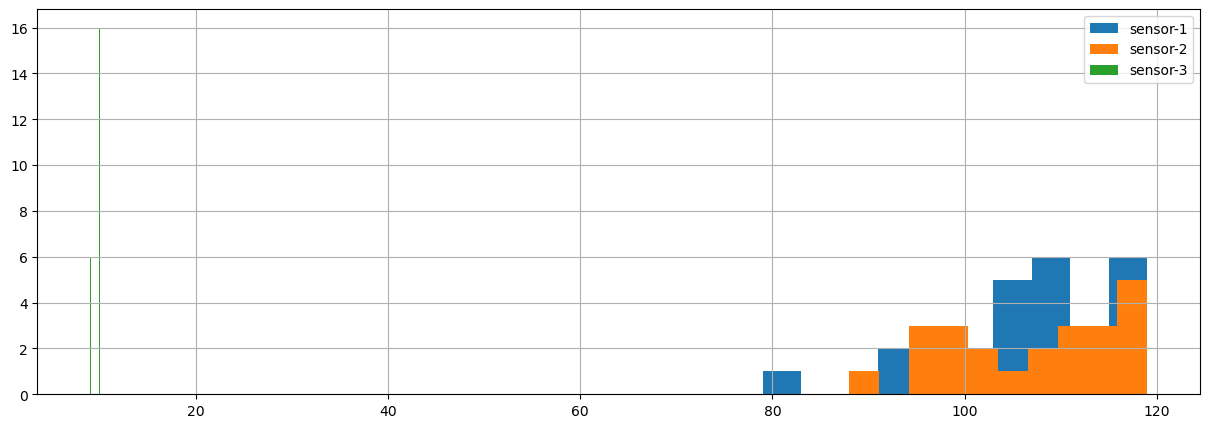

In [11]:
plt.figure(figsize=(15, 5))
sorted_df.groupby("sensor").max_time_delay.hist(legend=True)
plt.show()